### Imports

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

import tqdm
import torch

from torch.utils.data import DataLoader

%run models/models.ipynb

plt.style.use('dark_background')

### Datasets

In [2]:
MOVIE_DATASET_PATH = 'ml-1m/ratings.dat'

In [3]:
class MovieDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, sep='::', engine='python', header=None, categorize=True):
        
        column_names = [
            'user_id', 
            'movie_id', 
            'rating', 
            'timestamp'
        ]        
        
        data = pd.read_csv(dataset_path, sep=sep, engine=engine, header=header, 
                           names=column_names)
        
        self.data = data
        
        ratings = data['rating']
        
        if categorize:
            
            is_good_movie = ratings > 3
            
            ratings = ratings.mask(is_good_movie, 1)
            ratings = ratings.mask(- is_good_movie, 0)
        
        self.fields = data[['user_id', 'movie_id']] - 1        
        self.target = ratings
        
        self.fields = self.fields.to_numpy()[:1000]
        self.target = self.target.to_numpy()[:1000]
        
        self.embedding_dimensions = np.max(self.fields, axis=0) + 1


    def __len__(self):
        
        return self.fields.shape[0]
    

    def __getitem__(self, index):
        
        fields = self.fields[index]
        target = self.target[index]
        
        return fields, target

### Trainer

In [4]:
class Trainer:

    def __init__(self, dataset, model, criterion, metric, optimizer):
        
        self.dataset = dataset
        self.model = model
        self.criterion = criterion
        self.metric = metric
        self.optimizer = optimizer        
        
        self.fields = torch.tensor(dataset.fields, dtype=int)
        self.target = torch.tensor(dataset.target, dtype=int)
        
        # self.plot = OptionPricesPlot()
        
        
    def one_step(self):

        predictions = self.model(self.fields)

        loss = self.criterion(predictions, self.target.float())

        self.model.zero_grad()
        
        loss.backward()
        
        self.optimizer.step()

        return predictions, loss
    
    
    def train(self, epochs=10):
    
        model.train()

        for epoch in range(epochs):
            
            predictions, loss = self.one_step()
            
        print('loss:', loss)
        
        return predictions

### Movies - Prediction

In [5]:
# Data

dataset = MovieDataset(MOVIE_DATASET_PATH, categorize=False)

embedding_dimensions = dataset.embedding_dimensions


# Model

LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-6

%run models/models.ipynb

model = CustomDeepFactorizationMachineModel(embedding_dimensions, 
                                            embed_dim=16, mlp_dims=(16, 16), dropout=0.2)

# model = CustomLinearRegression(input_dimensions=len(embedding_dimensions),
#                                output_dimensions=1)

criterion = torch.nn.MSELoss()

metric = mean_squared_error

optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=LEARNING_RATE, 
                             weight_decay=WEIGHT_DECAY)

# # Others

# model = CustomLogisticRegression(embedding_dimensions)

# model = CustomFactorizationMachine(embedding_dimensions, embed_dim=16)

# criterion = torch.nn.BCELoss()

# optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)


trainer = Trainer(dataset=dataset,
                  model=model,
                  criterion=criterion,
                  metric=metric,
                  optimizer=optimizer)

In [6]:
predictions = trainer.train(epochs=1000)

loss: tensor(0.3993, grad_fn=<MseLossBackward0>)


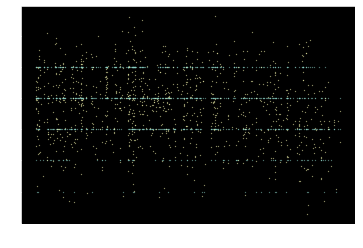

In [7]:
# Movies - 2D Plot

movie_id = trainer.fields[:, 1]
target_ratings = trainer.dataset.target
predicted_ratings = predictions.detach()

plt.scatter(movie_id, target_ratings, s=0.05)
plt.scatter(movie_id, predicted_ratings, s=0.05);